In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, BatchNormalization, MaxPooling2D, concatenate, Dropout, Lambda, RepeatVector, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
import numpy as np
import os
import timm
import tensorflow as tf
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
!unzip /content/drive/MyDrive/DATASET.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_7998.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8270.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_833.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8489.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8496.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8508.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8819.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8937.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8997.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9001.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9042.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9226.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9627.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9767.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9823.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_8_1

In [ ]:
image_size=(96,96)
code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}

images = []
vectors = []
labels = []

def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (np.linalg.norm(tl - bl)) > 0 and (np.linalg.norm(tl - tr)) > 0:
            boxes.append(box)
    return boxes

def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y
    else:
        for x,y in code.items():
            if n==y:
                return x

In [ ]:
def load_and_preprocess_data(images_path, path):

    for label, folder_path in enumerate(path):
        vec_files = os.listdir(folder_path)
        for vec_file in vec_files:
            filename = vec_file.split(".")[0]
            class_name = getcode(label)
            image_path = f"{images_path}/{class_name}/{filename}.jpeg"
            vector_path = f"{folder_path}{vec_file}"

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])

            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))

            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)

            #detecting the blood cell
            edgedImage = findedges(image1)
            edgedContours = getimageconturs(edgedImage)
            edgedBoxes =  getboxes(edgedContours, image.copy())

            if len(edgedBoxes)==0:
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))

            # draw the contour and fill it
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1)

            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0

            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                continue
            # resize th image

            image = cv2.resize(image, image_size)
            image = image / 255.0  # Normalize pixel values to [0, 1]

            vector = np.loadtxt(vector_path, delimiter=',')

            images.append(image)
            vectors.append(vector)
            labels.append(label)


In [ ]:
paths = [
    '/content/DATASET/TRAIN/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TRAIN/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TRAIN/VECTORS/MONOCYTE/',
    '/content/DATASET/TRAIN/VECTORS/NEUTROPHIL/',
]

test_paths = [
    '/content/DATASET/TEST/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TEST/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TEST/VECTORS/MONOCYTE/',
    '/content/DATASET/TEST/VECTORS/NEUTROPHIL/'
]


In [ ]:
load_and_preprocess_data("/content/DATASET/TRAIN/IMAGES", paths)

In [ ]:
load_and_preprocess_data("/content/DATASET/TEST/IMAGES", test_paths)

In [ ]:

images,vectors,labels=shuffle(images,vectors,labels,random_state=10)

In [ ]:
images = np.array(images)
vectors = np.array(vectors)
labels = np.array(labels)

In [ ]:
# Generate Train and Test using 80/20 split
train_image, test_image, train_vector, test_vector, train_label, test_label = train_test_split(images, vectors, labels, test_size=0.2, random_state=42)

In [ ]:
train_image = np.array(train_image, dtype = 'float32')
train_vector = np.array(train_vector, dtype = 'float32')
train_label = np.array(train_label, dtype = 'int32')

test_image = np.array(test_image, dtype = 'float32')
test_vector = np.array(test_vector, dtype = 'float32')
test_label = np.array(test_label, dtype = 'int32')

In [ ]:
print(train_image.shape, train_vector.shape, train_label.shape)
print(test_image.shape, test_vector.shape, test_label.shape)

(9716, 96, 96, 3) (9716, 10) (9716,)
(2430, 96, 96, 3) (2430, 10) (2430,)


In [ ]:
def create_model_without_knowledge(input_shape=(96, 96, 3), num_classes=4):
    image_input = Input(shape=input_shape)

    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=image_input)

    # Additional processing layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Output layer
    output = Dense(4, activation='softmax')(x)  # Assuming 4 classes

    # Define the model
    model = Model(inputs=image_input, outputs=output)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hoo

In [ ]:
def create_model_with_knowledge(input_shape=(96, 96, 3), num_classes=4):
    # Image input
    image_input = Input(shape=input_shape)

    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=image_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Vector input
    vector_input = Input((10,))
    y = Dense(64)(vector_input)
    y = Activation('relu')(y)
    y = Dropout(0.25)(y)

    # Concatenate image and vector features
    z = concatenate([y, x])
    z = Dense(64)(z)
    z = Activation('relu')(z)
    z = Dropout(.25)(z)

    z = Dense(64)(z)
    z = Activation('relu')(z)
    z = Dropout(.25)(z)

    # Output layer
    output = Dense(num_classes, activation='softmax')(z)

    # Define the model
    model = tf.keras.models.Model(inputs=[image_input, vector_input], outputs=output)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Create models
model_with_knowledge = create_model_with_knowledge()
model_without_knowledge = create_model_without_knowledge()

# Display model summaries
model_with_knowledge.summary()
model_without_knowledge.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 102, 102, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 48, 48, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
model_without_knowledge.fit(train_image, train_label, validation_split=0.1, epochs=30, batch_size=32)

Epoch 1/30
274/274 [==============================] - 112s 144ms/step - loss: 0.4142 - accuracy: 0.8493 - val_loss: 0.4240 - val_accuracy: 0.8591
Epoch 2/30
274/274 [==============================] - 28s 102ms/step - loss: 0.2170 - accuracy: 0.9143 - val_loss: 0.2576 - val_accuracy: 0.9064
Epoch 3/30
274/274 [==============================] - 28s 102ms/step - loss: 0.1611 - accuracy: 0.9396 - val_loss: 0.1501 - val_accuracy: 0.9496
Epoch 4/30
274/274 [==============================] - 28s 103ms/step - loss: 0.1363 - accuracy: 0.9480 - val_loss: 0.3027 - val_accuracy: 0.9033
Epoch 5/30
274/274 [==============================] - 29s 106ms/step - loss: 0.0973 - accuracy: 0.9651 - val_loss: 0.7584 - val_accuracy: 0.7767
Epoch 6/30
274/274 [==============================] - 28s 103ms/step - loss: 0.0816 - accuracy: 0.9703 - val_loss: 0.0890 - val_accuracy: 0.9691
Epoch 7/30
274/274 [==============================] - 29s 106ms/step - loss: 0.0982 - accuracy: 0.9644 - val_loss: 0.3719 - val_a

In [ ]:
loss1,accuracy1=model_without_knowledge.evaluate(test_image, test_label)
print("the accuracy of dense net model (pretrained model) without knowledge is : ",accuracy1)

76/76 [==============================] - 5s 62ms/step - loss: 0.0288 - accuracy: 0.9881
the accuracy of dense net model (pretrained model) without knowledge is :  0.9880658388137817


In [ ]:
model_without_knowledge.save('/content/drive/My Drive/DenseNetPretrainedModelWithoutKnowledge.keras')

In [ ]:
model_without_knowledge.save('/content/drive/My Drive/DenseNetPretrainedModelWithoutKnowledge.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_with_knowledge.fit([train_image, train_vector], train_label, validation_split=0.1, epochs=30, batch_size=32)

Epoch 1/30
274/274 [==============================] - 93s 117ms/step - loss: 0.3001 - accuracy: 0.8959 - val_loss: 0.2440 - val_accuracy: 0.9331
Epoch 2/30
274/274 [==============================] - 30s 111ms/step - loss: 0.1043 - accuracy: 0.9804 - val_loss: 5.0362 - val_accuracy: 0.7685
Epoch 3/30
274/274 [==============================] - 31s 112ms/step - loss: 0.0887 - accuracy: 0.9848 - val_loss: 528.8959 - val_accuracy: 0.2695
Epoch 4/30
274/274 [==============================] - 30s 109ms/step - loss: 0.0679 - accuracy: 0.9883 - val_loss: 0.0487 - val_accuracy: 0.9928
Epoch 5/30
274/274 [==============================] - 30s 110ms/step - loss: 0.0625 - accuracy: 0.9884 - val_loss: 0.0309 - val_accuracy: 0.9928
Epoch 6/30
274/274 [==============================] - 29s 107ms/step - loss: 0.0554 - accuracy: 0.9897 - val_loss: 0.6244 - val_accuracy: 0.9702
Epoch 7/30
274/274 [==============================] - 31s 111ms/step - loss: 0.0681 - accuracy: 0.9864 - val_loss: 1598.7792 - v

In [ ]:
loss2,accuracy2=model_with_knowledge.evaluate([test_image, test_vector], test_label)
print("the accuracy of dense net model (pretrained model) with knowledge is : ",accuracy2)

76/76 [==============================] - 3s 39ms/step - loss: 0.0396 - accuracy: 0.9905
the accuracy of dense net model (pretrained model) with knowledge is :  0.9905349612236023


In [ ]:
model_with_knowledge.save('/content/drive/My Drive/DenseNetPretrainedModelWithKnowledge.keras')

In [ ]:
model_with_knowledge.save('/content/drive/My Drive/DenseNetPretrainedModelWithKnowledge.h5')

Dense Net Pretrained Model Without Knowledge Results
76/76 [==============================] - 2s 27ms/step


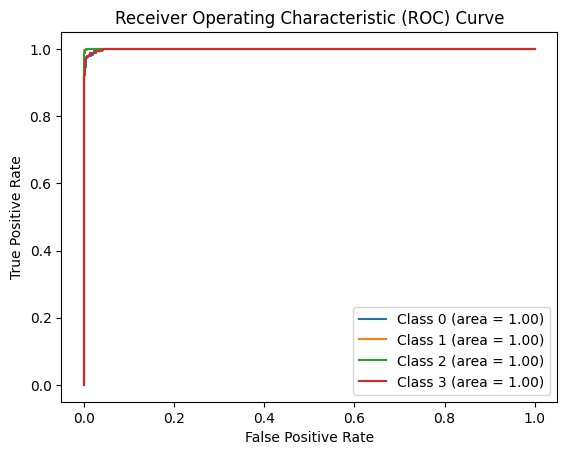

Accuracy: 0.9851851851851852
Class-wise Accuracy: [0.9790322580645161, 0.9935691318327974, 0.9932203389830508, 0.9749163879598662]
Precision: 0.9852237933452682
Recall: 0.9851851851851852
Specificity: 1.0
F1 Score: 0.9852044888869828
AUC: 0.9996188982740477


In [ ]:

def analyze_results(model, X_test, y_test):
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_true = y_test

    # Calculate overall accuracy
    accuracy = np.sum(np.argmax(y_pred, axis=1) == y_true) / len(y_true)
    num_classes=4
    # Calculate accuracy for each class
    class_accuracy = []
    for cls in range(num_classes):
        cls_indices = np.where(y_true == cls)[0]
        cls_accuracy = np.sum(np.argmax(y_pred[cls_indices], axis=1) == cls) / len(cls_indices)
        class_accuracy.append(cls_accuracy)

    # Calculate precision
    precision = precision_score(y_true, y_pred.argmax(axis=1), average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred.argmax(axis=1), average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))

    # Calculate specificity
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred, multi_class='ovr')

    # Plot ROC curve
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
        plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} (area = %0.2f)' % auc)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Print metrics
    print("Accuracy:", accuracy)
    print("Class-wise Accuracy:", class_accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Specificity:", specificity)
    print("F1 Score:", f1_score)
    print("AUC:", auc)

# Perform result analysis for model without knowledge
print("Dense Net Pretrained Model Without Knowledge Results")
analyze_results(model_without_knowledge, test_image, test_label)




In [ ]:
# Perform result analysis for model without knowledge
print("Dense Net Pretrained Model without knowledge Results")
analyze_results(model_without_knowledge, test_image, test_label)

Dense Net Pretrained Model without knowledge Results
76/76 [==============================] - 2s 22ms/step
Overall Accuracy: 0.9880658436213992
Class-wise Accuracy: [0.9870967741935484, 0.9967845659163987, 0.9932203389830508, 0.9749163879598662]
Precision (Per Class): [0.98076923 0.99678457 0.98819562 0.98646362]
Recall (Per Class): [0.98709677 0.99678457 0.99322034 0.97491639]
Specificity (Per Class): [0.98709677 0.99678457 0.99322034 0.97491639]
F1 Score (Per Class): [0.98392283 0.99678457 0.99070161 0.98065601]


In [ ]:
def analyze_results(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = y_test

    accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))

    num_classes = 4
    class_accuracy = []
    for cls in range(num_classes):
        cls_indices = np.where(y_true == cls)[0]
        cls_accuracy = accuracy_score(y_true[cls_indices], np.argmax(y_pred[cls_indices], axis=1))
        class_accuracy.append(cls_accuracy)

    # Calculate precision, recall, specificity, and F1 score for each class
    precision = precision_score(y_true, np.argmax(y_pred, axis=1), average=None)
    recall = recall_score(y_true, np.argmax(y_pred, axis=1), average=None)
    conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    specificity = conf_matrix.diagonal() / np.sum(conf_matrix, axis=1)
    f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average=None)

    # Print metrics
    print("Overall Accuracy:", accuracy)
    print("Class-wise Accuracy:", class_accuracy)
    print("Precision (Per Class):", precision)
    print("Recall (Per Class):", recall)
    print("Specificity (Per Class):", specificity)
    print("F1 Score (Per Class):", f1)

In [ ]:
from keras.models import load_model
model_without_knowledge = load_model('/content/drive/My Drive/DenseNetPretrainedModelWithoutKnowledge.keras')

In [ ]:
from sklearn.metrics import f1_score